In [1]:
import scipy.io as spio
import scipy
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [2]:
data_root = './datasets/'
N_KEYPOINTS = 14

KP_MAP = {
    0: "r_ankle",
    1: "r_knee",
    2: "r_hip",
    3: "l_hip",
    4: "l_knee",
    5: "l_ankle",
    6: "r_wrist",
    7: "r_elbow",
    8: "r_shoulder",
    9: "l_shoulder",
    10: "l_elbow",
    11: "l_wrist",
    12: "neck",
    13: "head_top",
}

In [3]:
def show_image(path, filename, keypoints=None):
    RADIUS = 2
    image = Image.open(os.path.join(path, filename))

    if keypoints:
        draw = ImageDraw.Draw(image)
        
        try:
            font = ImageFont.truetype("arial.ttf", 10)
        except IOError:
            font = ImageFont.load_default()

        for x, y, kp_id in keypoints:
            draw.ellipse((x-RADIUS, y-RADIUS, x+RADIUS, y+RADIUS), fill=(0, 255, 0), outline=(0, 255, 0))
            
            kp_name = KP_MAP.get(kp_id, "unknown")
            
            text_x, text_y = x + RADIUS + 2, y - RADIUS - 2  
            draw.text((text_x, text_y), kp_name, fill=(255, 0, 0), font=font)
        
    image.show()

def extract_keypoints(data=None, filename=None, only_visible=False):
    keypoints = []

    for id, keypoint in data[filename]['keypoints'].items():
        if not only_visible or (only_visible and keypoint['is_visible'] == 2):
            x, y = keypoint['x'], keypoint['y']
            keypoints.append((x, y, id))
    return keypoints

In [4]:
def print_dict_structure(d, indent=0):
    """
    Recursively prints the structure of a nested dictionary.
    """
    # Check if the current level is a dictionary
    if isinstance(d, dict):
        for key, value in d.items():
            print(" " * indent + f"{key}: {type(value).__name__}")
            # Recursively print the structure if value is a dictionary or list
            if isinstance(value, (dict, list)):
                print_dict_structure(value, indent + 2)
    elif isinstance(d, list):
        # Check the type of elements inside the list if it's not empty
        if len(d) > 0:
            print(" " * indent + f"[{type(d[0]).__name__} list]")
            for item in d:
                if isinstance(item, (dict, list)):
                    print_dict_structure(item, indent + 2)
        else:
            print(" " * indent + "[]")  # Empty list

## LSPe dataset

In [5]:
lspe_labels_path = os.path.join(data_root, 'lsp', 'joints.mat')
lspe_imgs_path = os.path.join(data_root, 'lsp', 'images')

In [6]:
#mat = scipy.io.loadmat(lspe_labels_path, simplify_cells=True)
mat = scipy.io.loadmat(lspe_labels_path, struct_as_record=False, squeeze_me=True)


In [7]:
annotations = mat['joints']
annotations.shape

(14, 3, 10000)

In [8]:
annotations = np.transpose(annotations, (2, 0, 1))
annotations.shape

(10000, 14, 3)

In [9]:
for id in range(10,20):
    print(annotations[id])

[[     170.63      85.194           1]
 [     149.51      89.684           1]
 [          0     -40.534           0]
 [     108.67      65.898           1]
 [     71.845      46.578           1]
 [     31.432       28.18           1]
 [     99.684       95.51           1]
 [          0     -40.534           0]
 [          0     -40.534           0]
 [      137.4      73.083           1]
 [      138.3      89.248           1]
 [     131.12      104.05           1]
 [          0     -40.534           0]
 [     116.75      76.675           1]]
[[     57.461      198.87           1]
 [     58.278      156.82           1]
 [     51.744         107           1]
 [     66.865      107.81           1]
 [      102.8      103.73           1]
 [     74.614      130.68           1]
 [     90.552      64.923           1]
 [     86.865      89.426           1]
 [     74.614       71.06           1]
 [     51.744      64.525           1]
 [     66.865      63.709           1]
 [     86.468      59.62

Create dictionary while removing image with incomplete keypoints (negative values)

In [10]:
len(annotations)

10000

In [11]:
annotations[0]

array([[          0,     -26.109,           0],
       [     26.031,       86.41,           1],
       [     50.608,      75.701,           1],
       [      71.73,      87.567,           1],
       [      49.17,      89.006,           1],
       [     23.139,       94.79,           1],
       [     131.31,      13.805,           1],
       [     111.64,       34.63,           1],
       [     93.711,      49.091,           1],
       [     102.39,      68.462,           1],
       [     110.78,      88.427,           1],
       [     139.13,      89.584,           1],
       [     96.885,      56.611,           1],
       [     116.57,      53.422,           1]])

COCO is_visible values used in YOLO:
 - 0: Not labeled
 - 1: Labelled but not visible
 - 2: Labeled and visible.

In this case (LSPe dataset), non-visible points have unknown coordinates. So, values will be either 0 or 2

In [12]:
lspe_data = {}
lspe_filenames = os.listdir(lspe_imgs_path)
for i in range(len(annotations)): # image
    keypoints = {
                    'keypoints': {}
                  }        
    for j, keypoint in enumerate(annotations[i]):
        x, y, is_visible = keypoint   # x, y, visible

        visibility = 0
        if x >= 0 and y >= 0 and is_visible == 1:
            visibility = 2
        elif x > 0 and y > 0 and is_visible == 0:
            visibility = 1
        if visibility == 0:
            kp = {'x': 0, 'y': 0, 'is_visible': 0}
        else:
            kp = {'x': int(x), 'y': int(y), 'is_visible': visibility}
        keypoints['keypoints'][j] = kp

    lspe_data[lspe_filenames[i]] = keypoints


Check that no keypoint has visibility 1 (labelled but not visible)

In [13]:
for k,v in lspe_data.items():
    for id,keypoint in v['keypoints'].items():
        if keypoint['is_visible'] == 1:
            print(v)

Add image size information

In [14]:
for elem in os.listdir(lspe_imgs_path):
    img = Image.open(os.path.join(lspe_imgs_path, elem))

    lspe_data[elem]['size'] = (img.size)

## Check images and labels

Total images

In [15]:
print(f'LSPe images: {len(lspe_data)}')

LSPe images: 10000


Check number of keypoints

In [16]:
for key,item in lspe_data.items():
    if len(item['keypoints']) != N_KEYPOINTS:
            print(id, len(item['keypoints']), item)

In [17]:
lspe_data[lspe_filenames[id]]

{'keypoints': {0: {'x': 39, 'y': 98, 'is_visible': 2},
  1: {'x': 60, 'y': 92, 'is_visible': 2},
  2: {'x': 86, 'y': 73, 'is_visible': 2},
  3: {'x': 105, 'y': 88, 'is_visible': 2},
  4: {'x': 83, 'y': 99, 'is_visible': 2},
  5: {'x': 52, 'y': 103, 'is_visible': 2},
  6: {'x': 50, 'y': 87, 'is_visible': 2},
  7: {'x': 74, 'y': 61, 'is_visible': 2},
  8: {'x': 96, 'y': 37, 'is_visible': 2},
  9: {'x': 127, 'y': 44, 'is_visible': 2},
  10: {'x': 119, 'y': 75, 'is_visible': 2},
  11: {'x': 107, 'y': 104, 'is_visible': 2},
  12: {'x': 116, 'y': 41, 'is_visible': 2},
  13: {'x': 133, 'y': 21, 'is_visible': 2}},
 'size': (191, 127)}

Check labels

In [18]:
for filename, image in lspe_data.items():
    width, height = image['size']
    for id, kp in image['keypoints'].items():
        if kp['x'] < 0 or kp['x'] > width or kp['y'] < 0 or kp['y'] > height:
            print('Invalid keypoint', filename, 'kp_id:', id, kp)

Invalid keypoint im08075.jpg kp_id: 1 {'x': 386, 'y': 150, 'is_visible': 2}


Ad-hoc correction

In [19]:
lspe_data['im08075.jpg']['keypoints'][1] = {'x': 90, 'y': 116, 'is_visible': 2}

Check image dimensions

In [20]:
sizes = []
for elem in os.listdir(lspe_imgs_path):
    sizes.append(lspe_data[elem]['size'])
sizes_set = set(sizes)

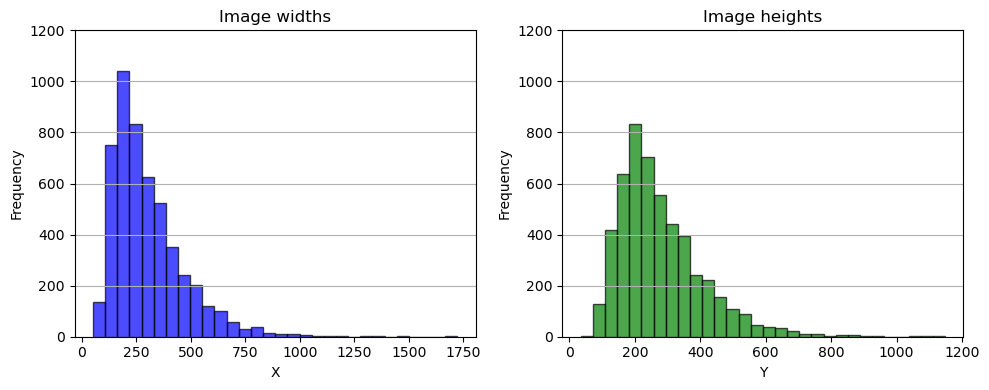

In [22]:
x_values = [size[0] for size in sizes_set]
y_values = [size[1] for size in sizes_set]
h_max = 1200

plt.figure(figsize=(10, 4))

# histogram for X values
plt.subplot(1, 2, 1)
plt.ylim(0, h_max)
plt.hist(x_values, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Image widths')
plt.xlabel('X')
plt.ylabel('Frequency')
plt.grid(axis='y')

# histogram for Y values
plt.subplot(1, 2, 2)
plt.ylim(0, h_max)
plt.hist(y_values, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Image heights')
plt.xlabel('Y')
plt.ylabel('Frequency')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Visualizing random samples

In [29]:
ids = np.random.rand(5)*100
ids = [int(elem) for elem in ids]

print(ids)

[21, 70, 74, 52, 80]


In [34]:
for id in ids:
    show_image(lspe_imgs_path, lspe_filenames[id], extract_keypoints(lspe_data, lspe_filenames[id], only_visible=True))

## Test inference

In [25]:
ID = 22
show_image(lspe_imgs_path, lspe_filenames[ID], extract_keypoints(lspe_data, lspe_filenames[ID], only_visible=True))

In [26]:
model = YOLO("yolo11n-pose.pt")

test_image = os.path.join(lspe_imgs_path, lspe_filenames[ID])
results = model(test_image, save=True, save_dir='./runs/pose')

c:\Users\Andrea\miniconda3\envs\torch\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


image 1/1 c:\Users\Andrea\Uni\IPCV\progetto\datasets\lsp\images\im00023.jpg: 640x448 3 persons, 109.5ms
Speed: 2.0ms preprocess, 109.5ms inference, 51.0ms postprocess per image at shape (1, 3, 640, 448)
Results saved to runs\pose\predict


## Train/val/test split

In [ ]:
import os
import shutil
import random

split_folder = os.path.join(data_root, 'split')

if not os.path.exists(split_folder):
    os.makedirs(split_folder)

for subfolder in ['train', 'val', 'test']:
    subfolder_path = os.path.join(split_folder, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

image_files = [f for f in os.listdir(lspe_imgs_path) if os.path.isfile(os.path.join(lspe_imgs_path, f))]

# 80 / 10 / 10
total_images = len(image_files)
train_size = int(total_images * 0.8)
val_size = int(total_images * 0.1)
test_size = total_images - train_size - val_size

train_images = image_files[:train_size]
val_images = image_files[train_size:train_size + val_size]
test_images = image_files[train_size + val_size:]

def copy_images(images, folder):
    for image in images:
        src_path = os.path.join(lspe_imgs_path, image)
        dst_path = os.path.join(split_folder, folder, image)
        shutil.copy(src_path, dst_path)

# Move the images to their respective folders
# copy_images(train_images, 'train')
# copy_images(val_images, 'val')
# copy_images(test_images, 'test')

print(f"Data split completed! {len(train_images)} images in 'train', {len(val_images)} in 'val', and {len(test_images)} in 'test'.")


Data split completed! 8000 images in 'train', 1000 in 'val', and 1000 in 'test'.


## Convert to YOLO format

Utility functions

In [65]:
def calculate_bounding_box(img_file, padding_factor=0.5, verbose=False):
    img_data = lspe_data[img_file]

    # calculate bbox only on visible keypoints
    keypoints = [keypoint for _, keypoint in img_data['keypoints'].items() if keypoint['is_visible'] !=0 ]
    image_width, image_height = img_data['size']

    x_coords = [kp['x'] for kp in keypoints]
    y_coords = [kp['y'] for kp in keypoints]
    
    # get extreme keypoints
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)
    
    # calculate the bbox center, width and height
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    b_width = max_x - min_x
    b_height = max_y - min_y

    if padding_factor > 0:
        # add some padding without exceeding image dimension
        # padding_factor = 0.5 means 0.25 in each direction
        if verbose:
            print(f'{img_file} before b_height: {b_height}, b_width: {b_width}')

        remaining_y_up = center_y - int(b_height/2)
        remaining_y_down = image_height - (center_y + int(b_height)/2)
        max_padding_y = 2*min(remaining_y_up, remaining_y_down) # minimum of these two is the amount i can safely add both above and below
        b_height += min(max_padding_y, padding_factor*b_height) # add a percentage of box height without exceeding image dimension

        remaining_x_left = center_x - int(b_width/2)
        remaining_x_right = image_width - (center_x + int(b_width)/2)
        max_padding_x = 2*min(remaining_x_left, remaining_x_right)
        b_width += min(max_padding_x, padding_factor*b_width)

        if verbose:
            print(f'{img_file} after b_height: {b_height}, b_width: {b_width}')
    
    # normalized bbox coordinates
    norm_center_x = min(center_x / image_width, 1)
    norm_center_y = min(center_y / image_height, 1)
    norm_width = min(b_width / image_width, 1)
    norm_height = min(b_height / image_height, 1)
    
    return {
        'x': norm_center_x,
        'y': norm_center_y,
        'width': norm_width,
        'height': norm_height
    }

def show_bounding_box(img_path, bbox, color=(0, 255, 0), thickness=2):

    image = cv2.imread(img_path)
    image_height, image_width, _ = image.shape
    
    # denormalize bbox coordinates
    center_x = bbox['x'] * image_width
    center_y = bbox['y'] * image_height
    width = bbox['width'] * image_width
    height = bbox['height'] * image_height
    
    # draw rectangle
    x_min = int(center_x - width / 2)
    x_max = int(center_x + width / 2)
    y_min = int(center_y - height / 2)
    y_max = int(center_y + height / 2)
    
    image = cv2.line(image, (x_min, y_min), (x_max, y_min), color, thickness) 
    image = cv2.line(image, (x_max, y_min), (x_max, y_max), color, thickness)
    image = cv2.line(image, (x_max, y_max), (x_min, y_max), color, thickness)
    image = cv2.line(image, (x_min, y_max), (x_min, y_min), color, thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_bbox = Image.fromarray(image)
    image_bbox.show()

Check bounding boxes

In [66]:
ids = np.random.rand(5)*100
ids = [int(elem) for elem in ids][:2]

for id in ids:
    img_file = lspe_filenames[id]
    img_path = os.path.join(lspe_imgs_path, img_file)

    # without padding
    bbox = calculate_bounding_box(img_file, padding_factor=0)
    show_bounding_box(img_path, bbox)
    
    # with padding
    bbox = calculate_bounding_box(img_file, padding_factor=0.5, verbose=True)
    show_bounding_box(img_path, bbox)

im00080.jpg before b_height: 87, b_width: 89
im00080.jpg after b_height: 124.0, b_width: 133.5
im00063.jpg before b_height: 94, b_width: 108
im00063.jpg after b_height: 141.0, b_width: 162.0


Write YOLO label files

In [ ]:
split_folder = os.path.join(data_root, 'split')
for dir in os.listdir(split_folder):
    folder = os.path.join(split_folder, dir)
    for file in os.listdir(folder):
        
        bbox = calculate_bounding_box(file, verbose=False)
        img_width, img_height = lspe_data[file]['size']

        # <class-index> <x> <y> <width> <height> <px1> <py1> <p1-visibility> ...  <pxn> <pyn> <pn-visibility>
        # class 0 = person

        yolo_label = f'0 {bbox['x']} {bbox['y']} {bbox['width']} {bbox['height']} '

        for id in range(N_KEYPOINTS):
            kp = lspe_data[file]['keypoints'][id]

            x, y, visibility = kp['x']/img_width, kp['y']/img_height, kp['is_visible']
            if x > 1 or y > 1:
                print(kp, x, y, file, img_width, img_height)
                
            yolo_label += f'{x} {y} {visibility} '

        yolo_label = yolo_label[:-1]

        filename = file.split('.')[0] + '.txt'
        label_file = os.path.join(split_folder, dir, filename)

        with open(label_file, 'w') as file:
            file.write(yolo_label)